In [1]:
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import time
import torch
torch.set_num_threads(36)
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from datetime import timedelta
from efficientnet_pytorch import EfficientNet
from scipy.interpolate import griddata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

import sys
sys.path.insert(0, '/home/jupyter/deepfake-kaggle/utils')
from senet import se_resnext50_32x4d
from radam import RAdam
from lookahead import Lookahead
import radialProfile

METADATA_DIR = '/home/jupyter/data/metadata'
FACES_DIR = '/home/jupyter/faces_saved'

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
%%time

with open('/home/jupyter/faces_pickled/train_faces.pickle', 'rb') as handle:
    train_faces = pickle.load(handle)

with open('/home/jupyter/faces_pickled/dev_faces.pickle', 'rb') as handle:
    dev_faces = pickle.load(handle)
    
with open('/home/jupyter/faces_pickled/test_faces.pickle', 'rb') as handle:
    test_faces = pickle.load(handle)
    
with open('/home/jupyter/faces_pickled/train_target.pickle', 'rb') as handle:
    train_target = pickle.load(handle)
    
with open('/home/jupyter/faces_pickled/dev_target.pickle', 'rb') as handle:
    dev_target = pickle.load(handle)
    
with open('/home/jupyter/faces_pickled/test_target.pickle', 'rb') as handle:
    test_target = pickle.load(handle)

len(train_faces), len(dev_faces), len(test_faces), len(train_target), len(dev_target), len(test_target)

CPU times: user 120 ms, sys: 84 ms, total: 204 ms
Wall time: 198 ms


(1063586, 10792, 10803, 1063586, 10792, 10803)

https://github.com/cc-hpc-itwm/DeepFakeDetection/blob/master/Experiments_DeepFakeDetection/FaceForensic.ipynb

## Train

In [3]:
data = {}
epsilon = 1e-8
N = 80
y = []
error = []

np.random.seed(13)

NUMBER_OF_FACES = 100000

def extract_features(filenames, start_time=time.time(), num_workers=8):
    def process_file(i):
        file = filename = '/home/jupyter/' + filenames[i]
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation
        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        if i % 500 == 0:
            print('{}/{} ({:.2f}%) passed ({} / {})'.format(
                i,
                len(filenames),
                i / len(filenames) * 100,
                timedelta(seconds=time.time() - start_time),
                timedelta(seconds=time.time() - start_time) / (i + 1e-8) * len(filenames)
            ))
        return interpolated

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        interpolated_array = ex.map(process_file, range(len(filenames)))
        
    return np.array(list(interpolated_array))

# fake
fakes_idx = [i for i in range(len(train_target)) if train_target[i] == 1]
fakes_idx_small = np.random.choice(fakes_idx, size=int(NUMBER_OF_FACES // 2), replace=False)
fakes_target_small = np.array(train_target)[fakes_idx_small]
fakes_faces_small = np.array(train_faces)[fakes_idx_small]
n_fakes = len(fakes_idx_small)

psd1D_total = extract_features(fakes_faces_small)
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

# real
reals_idx = [i for i in range(len(train_target)) if train_target[i] == 0]
reals_idx_small = np.random.choice(reals_idx, size=int(NUMBER_OF_FACES // 2), replace=False)
reals_target_small = np.array(train_target)[reals_idx_small]
reals_faces_small = np.array(train_faces)[reals_idx_small]
n_reals = len(reals_idx_small)

psd1D_total2 = extract_features(reals_faces_small)
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)
            
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((fakes_target_small, reals_target_small), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

0/50000 (0.00%) passed (0:00:01.232565 / 71329745 days, 8:53:20)
500/50000 (1.00%) passed (0:01:01.834850 / 1:43:03.500000)
1000/50000 (2.00%) passed (0:01:59.957586 / 1:39:57.900000)
1500/50000 (3.00%) passed (0:02:59.663860 / 1:39:48.800000)
2000/50000 (4.00%) passed (0:03:58.272331 / 1:39:16.800000)
2500/50000 (5.00%) passed (0:04:58.016949 / 1:39:20.350000)
3000/50000 (6.00%) passed (0:05:57.075131 / 1:39:11.250000)
3500/50000 (7.00%) passed (0:06:55.580490 / 1:38:56.850000)
4000/50000 (8.00%) passed (0:07:55.305993 / 1:39:01.350000)
4500/50000 (9.00%) passed (0:08:52.596237 / 1:38:37.750000)
5000/50000 (10.00%) passed (0:09:50.184843 / 1:38:21.850000)
5500/50000 (11.00%) passed (0:10:47.653752 / 1:38:07.750000)
6000/50000 (12.00%) passed (0:11:45.691910 / 1:38:00.750000)
6500/50000 (13.00%) passed (0:12:44.037412 / 1:37:57.200000)
7000/50000 (14.00%) passed (0:13:41.302344 / 1:37:46.450000)
7500/50000 (15.00%) passed (0:14:39.645060 / 1:37:44.300000)
8000/50000 (16.00%) passed (0:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/jupyter/deepfake-kaggle/utils/radialProfile.py:37: RuntimeWarning: invalid value encountered in subtract
  tbin = csim[rind[1:]] - csim[rind[:-1]]


9000/50000 (18.00%) passed (0:17:34.971759 / 1:37:40.950000)
9500/50000 (19.00%) passed (0:18:30.843226 / 1:37:26.550000)
10000/50000 (20.00%) passed (0:19:30.558471 / 1:37:32.800000)
10500/50000 (21.00%) passed (0:20:29.163935 / 1:37:33.150000)
11000/50000 (22.00%) passed (0:21:28.247996 / 1:37:35.650000)
11500/50000 (23.00%) passed (0:22:27.105671 / 1:37:37)
12000/50000 (24.00%) passed (0:23:25.560112 / 1:37:36.500000)
12500/50000 (25.00%) passed (0:24:25.470762 / 1:37:41.900000)
13000/50000 (26.00%) passed (0:25:24.404701 / 1:37:43.100000)
13500/50000 (27.00%) passed (0:26:24.431780 / 1:37:48.250000)
14000/50000 (28.00%) passed (0:27:21.987552 / 1:37:44.250000)
14500/50000 (29.00%) passed (0:28:19.356617 / 1:37:39.850000)
15000/50000 (30.00%) passed (0:29:19.803169 / 1:37:46)
15500/50000 (31.00%) passed (0:30:19.758210 / 1:37:50.200000)
16000/50000 (32.00%) passed (0:31:17.516611 / 1:37:47.250000)
16500/50000 (33.00%) passed (0:32:13.361685 / 1:37:38.650000)
17000/50000 (34.00%) pas

26000/50000 (52.00%) passed (2:29:00.620661 / 4:46:33.500000)
26500/50000 (53.00%) passed (2:29:59.895713 / 4:43:00.950000)
27000/50000 (54.00%) passed (2:31:01.595190 / 4:39:40.750000)
27500/50000 (55.00%) passed (2:32:00.421853 / 4:36:22.600000)
28000/50000 (56.00%) passed (2:32:59.498378 / 4:33:11.950000)
28500/50000 (57.00%) passed (2:33:58.233980 / 4:30:07.450000)
29000/50000 (58.00%) passed (2:34:56.213229 / 4:27:07.950000)
29500/50000 (59.00%) passed (2:35:54.981794 / 4:24:15.900000)
30000/50000 (60.00%) passed (2:36:52.560864 / 4:21:27.600000)
30500/50000 (61.00%) passed (2:37:52.710379 / 4:18:49.050000)
31000/50000 (62.00%) passed (2:38:49.820865 / 4:16:10.700000)
31500/50000 (63.00%) passed (2:39:49.987320 / 4:13:42.200000)
32000/50000 (64.00%) passed (2:40:49.225260 / 4:11:16.900000)
32500/50000 (65.00%) passed (2:41:50.875236 / 4:08:59.800000)
33000/50000 (66.00%) passed (2:42:51.789759 / 4:06:45.750000)
33500/50000 (67.00%) passed (2:43:50.886343 / 4:04:32.950000)
34000/50

OverflowError: normalized days too large to fit in a C int

In [10]:
# sorry, forgot try except :/

def extract_features(filenames, start_time=time.time(), num_workers=8):
    def process_file(i):
        file = filename = '/home/jupyter/' + filenames[i]
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation
        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        if i % 500 == 0:
            try:
                print('{}/{} ({:.2f}%) passed ({} / {})'.format(
                    i,
                    len(filenames),
                    i / len(filenames) * 100,
                    timedelta(seconds=time.time() - start_time),
                    timedelta(seconds=time.time() - start_time) / (i + 1e-8) * len(filenames)
                ))
            except:
                pass
        return interpolated

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        interpolated_array = ex.map(process_file, range(len(filenames)))
        
    return np.array(list(interpolated_array))

# real
reals_idx = [i for i in range(len(train_target)) if train_target[i] == 0]
reals_idx_small = np.random.choice(reals_idx, size=int(NUMBER_OF_FACES // 2), replace=False)
reals_target_small = np.array(train_target)[reals_idx_small]
reals_faces_small = np.array(train_faces)[reals_idx_small]
n_reals = len(reals_idx_small)

psd1D_total2 = extract_features(reals_faces_small)
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)
            
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((fakes_target_small, reals_target_small), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

0/50000 (0.00%) passed (0:00:00.988150 / 57185069 days, 10:40:00)
500/50000 (1.00%) passed (0:01:00.898249 / 1:41:29.850000)
1000/50000 (2.00%) passed (0:01:59.081509 / 1:39:14.100000)
1500/50000 (3.00%) passed (0:03:01.037119 / 1:40:34.550000)
2000/50000 (4.00%) passed (0:04:01.879067 / 1:40:47)
2500/50000 (5.00%) passed (0:05:02.646601 / 1:40:52.950000)
3000/50000 (6.00%) passed (0:05:59.435721 / 1:39:50.600000)
3500/50000 (7.00%) passed (0:06:58.994462 / 1:39:45.650000)
4000/50000 (8.00%) passed (0:07:57.218815 / 1:39:25.250000)
4500/50000 (9.00%) passed (0:08:58.934756 / 1:39:48.150000)
5000/50000 (10.00%) passed (0:09:56.729846 / 1:39:27.300000)
5500/50000 (11.00%) passed (0:10:54.100931 / 1:39:06.350000)
6000/50000 (12.00%) passed (0:11:50.597246 / 1:38:41.650000)
6500/50000 (13.00%) passed (0:12:50.800996 / 1:38:49.250000)
7000/50000 (14.00%) passed (0:13:49.049578 / 1:38:41.800000)
7500/50000 (15.00%) passed (0:14:48.102078 / 1:38:40.700000)
8000/50000 (16.00%) passed (0:15:42.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


24000/50000 (48.00%) passed (0:47:06.381507 / 1:38:08.300000)
24500/50000 (49.00%) passed (0:48:05.268992 / 1:38:08.300000)
25000/50000 (50.00%) passed (0:49:06.147193 / 1:38:12.300000)
25500/50000 (51.00%) passed (0:50:05.843133 / 1:38:13.800000)
26000/50000 (52.00%) passed (0:51:04.459330 / 1:38:13.200000)
26500/50000 (53.00%) passed (0:52:03.060047 / 1:38:12.550000)
27000/50000 (54.00%) passed (0:53:01.839129 / 1:38:12.300000)
27500/50000 (55.00%) passed (0:54:02.054586 / 1:38:14.650000)
28000/50000 (56.00%) passed (0:55:02.751196 / 1:38:17.750000)
28500/50000 (57.00%) passed (0:56:01.341450 / 1:38:17.100000)
29000/50000 (58.00%) passed (0:56:59.645035 / 1:38:15.950000)
29500/50000 (59.00%) passed (0:57:58.536985 / 1:38:15.850000)
30000/50000 (60.00%) passed (0:58:57.410012 / 1:38:15.700000)
30500/50000 (61.00%) passed (0:59:58.297617 / 1:38:18.850000)
31000/50000 (62.00%) passed (1:00:57.796159 / 1:38:19.650000)
31500/50000 (63.00%) passed (1:01:57.866129 / 1:38:21.350000)
32000/50

In [16]:
output = open('/home/jupyter/deepfake-kaggle/data_simple_features/train_{}.pickle'.format(NUMBER_OF_FACES), 'wb')
pickle.dump(data, output)
output.close()

## Val

In [19]:
X.shape

(100000, 80)

In [25]:
num_feat

80

In [39]:
psd1D_org_1[:, x][np.logical_not(np.isnan(psd1D_org_1[:, x]))]

array([1.        , 0.87410209, 0.86543287, ..., 0.34007143, 0.32953335,
       0.33026416])

In [40]:
psd1D_org_1[:, x]

array([[1.        , 0.87410209, 0.86543287, ..., 0.33267728, 0.32506226,
        0.31207179],
       [1.        , 0.94649209, 0.89985435, ..., 0.30357105, 0.32005142,
        0.32503539],
       [1.        , 0.92104816, 0.86268718, ..., 0.36077642, 0.3349325 ,
        0.34525677],
       ...,
       [1.        , 0.92342985, 0.87999981, ..., 0.32403209, 0.33772962,
        0.32436192],
       [1.        , 0.92032494, 0.84742105, ..., 0.30383151, 0.31220828,
        0.31371006],
       [1.        , 0.92406207, 0.8778988 , ..., 0.34007143, 0.32953335,
        0.33026416]])

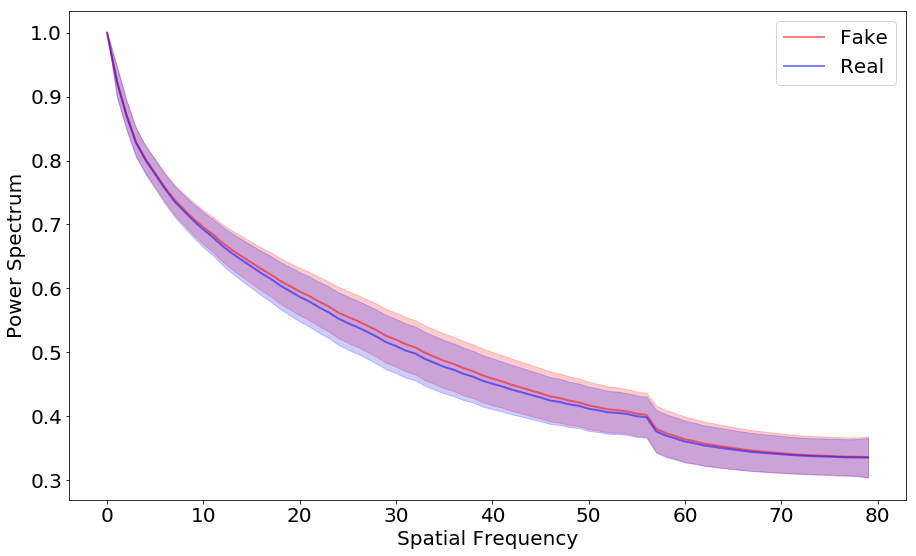

In [65]:
X = data["data"]
y = data["label"]

num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

psd1D_org_0 = psd1D_org_0[~np.isnan(psd1D_org_0).any(axis=1)]
psd1D_org_1 = psd1D_org_1[~np.isnan(psd1D_org_1).any(axis=1)]


# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
plt.show()

In [68]:
data = {}
epsilon = 1e-8
N = 80
y = []
error = []

np.random.seed(13)

NUMBER_OF_FACES = 3800

def extract_features(filenames, start_time=time.time(), num_workers=8):
    def process_file(i):
        file = filename = '/home/jupyter/' + filenames[i]
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation
        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        if i % 500 == 0:
            try:
                print('{}/{} ({:.2f}%) passed ({} / {})'.format(
                    i,
                    len(filenames),
                    i / len(filenames) * 100,
                    timedelta(seconds=time.time() - start_time),
                    timedelta(seconds=time.time() - start_time) / (i + 1e-8) * len(filenames)
                ))
            except:
                pass
        return interpolated

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        interpolated_array = ex.map(process_file, range(len(filenames)))
        
    return np.array(list(interpolated_array))

# fake
fakes_idx = [i for i in range(len(dev_target)) if dev_target[i] == 1]
fakes_idx_small = np.random.choice(fakes_idx, size=int(NUMBER_OF_FACES // 2), replace=False)
fakes_target_small = np.array(dev_target)[fakes_idx_small]
fakes_faces_small = np.array(dev_faces)[fakes_idx_small]
n_fakes = len(fakes_idx_small)

psd1D_total = extract_features(fakes_faces_small)
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

# real
reals_idx = [i for i in range(len(dev_target)) if dev_target[i] == 0]
reals_idx_small = np.random.choice(reals_idx, size=int(NUMBER_OF_FACES // 2), replace=False)
reals_target_small = np.array(dev_target)[reals_idx_small]
reals_faces_small = np.array(dev_faces)[reals_idx_small]
n_reals = len(reals_idx_small)

psd1D_total2 = extract_features(reals_faces_small)
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

psd1D_total = psd1D_total[~np.isnan(psd1D_total).any(axis=1)]
psd1D_total2 = psd1D_total2[~np.isnan(psd1D_total2).any(axis=1)]
            
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((fakes_target_small, reals_target_small), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

0/1900 (0.00%) passed (0:00:01.338377 / 2943214 days, 8:26:40)
500/1900 (26.32%) passed (0:00:59.485582 / 0:03:46.044900)
1000/1900 (52.63%) passed (0:01:57.639103 / 0:03:43.514100)
1500/1900 (78.95%) passed (0:02:56.424689 / 0:03:43.470400)
0/1900 (0.00%) passed (0:03:46.112741 / 497238686 days, 8:13:20)
500/1900 (26.32%) passed (0:04:43.683021 / 0:17:57.995400)
1000/1900 (52.63%) passed (0:05:42.489211 / 0:10:50.729100)
1500/1900 (78.95%) passed (0:06:42.179359 / 0:08:29.428000)


In [69]:
output = open('/home/jupyter/deepfake-kaggle/data_simple_features/dev_{}.pickle'.format(NUMBER_OF_FACES), 'wb')
pickle.dump(data, output)
output.close()

In [76]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pickle

#train
pkl_file = open('/home/jupyter/deepfake-kaggle/data_simple_features/train_100000.pickle', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
not_nan_idx = np.where(~np.isnan(X).any(axis=1))[0]
X = X[not_nan_idx]
y = data["label"]
y = y[not_nan_idx]

#test
pkl_file = open('/home/jupyter/deepfake-kaggle/data_simple_features/dev_3800.pickle', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
not_nan_idx = np.where(~np.isnan(X).any(axis=1))[0]
X = X[not_nan_idx]
y_ = data["label"]
y = y[not_nan_idx]

In [ ]:
logreg = LogisticRegression(penalty='l1', C=10000, random_state=13)
logreg.fit(X, y)
LR = roc_auc_score(y_, logreg.predict_proba(X_)[:, 1])
print("LR: "+str(LR))

In [83]:
logreg = LogisticRegression(C=10000, random_state=13)
logreg.fit(X, y)
LR = roc_auc_score(y_, logreg.predict_proba(X_)[:, 1])
print("LR: "+str(LR))

LR: 0.5954728531855955
